<a href="https://colab.research.google.com/github/Jose-Balocchi/Proyecto2---Music-Guess/blob/main/Proyecto_2_good.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alternativa 1: Predicción de género musical

1) Fuente de datos

https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre

2) Breve descripción de datos

El dataset entrega una serie de caracteristicas de canciones incluyendo el genero musical, artista y nombre de cancion y otras caracteristicas mas tecnicas.

3) ¿Cuál es el objetivo?

El objetivo será determinar el genero musical de una cancion en base a las caracteristicas del dataset. Otra alternativa puede ser que en base a las caracteristicas se pueda determinar el nombre del artista, pero eso dependera de la cantidad de canciones por artista que podamos encontrar.

4) ¿Este es un problema de clasificación o regresión?

De clasificación.

5) ¿Cuántas características hay?

18

6) ¿Cuántas filas de datos hay?

50.000

7) ¿Qué retos, si es que hay alguno, prevén en la limpieza, exploración o modelización con este conjunto de datos?

Si por ejemplo queremos predecir el artista en base a las caracteristicas de las canciones vamos a necesitar hacer sub grupos de datos, por ej de musica clasica y asi poder identificar al autor (Mozart, Bach, etc).

Dado lo anterior, este tambien seria un modelo multiclase.

In [3]:
# modelos y bibliotecas
import pandas as pd
import numpy as np
import tensorflow as tf

# Graficos
import matplotlib.pyplot as plt
import seaborn as sns

# Herramientas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
import datetime

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluacion modelos
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score

from sklearn import set_config
set_config(display='diagram')

# Boost
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import set_config
set_config(display='diagram')

# No Supervisado
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

#Reduccion de Dimensionalidad
from sklearn.decomposition import PCA

# Redes
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.linear_model import Perceptron
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import losses, metrics, optimizers

from tensorflow import keras

In [4]:
df= pd.read_csv('/content/music_genre.csv')
df.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [6]:
# Podemos ver que practicamente no hay valores nulos. De esos valores sólo eliminaremos las filas correspondientes a nuestra variable objetivo music genre

In [7]:
df.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.212526e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,0.456264
std,20725.256253,15.542008,0.341340,0.178632,1.286720e+05,0.264559,0.325409,0.161637,6.162990,0.101373,0.247119
min,20002.000000,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,0.000000
25%,37973.500000,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,0.257000
50%,55913.500000,45.000000,0.144000,0.568000,2.192810e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,0.448000
75%,73863.250000,56.000000,0.552000,0.687000,2.686122e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,0.992000


In [8]:
# Ahora veamos si hay datos duplicados

df.duplicated().sum()

4

In [9]:
# Eliminiaremos los datos duplicados

df = df.drop_duplicates()

In [10]:
df.duplicated().sum()

0

In [11]:
df = df.dropna(subset = ['music_genre'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [12]:
# Tambien podemos ver que hay muchas columnas que debieran ser float y aparecen como object.

In [13]:
df['danceability'].value_counts()

0.5290    143
0.6570    139
0.6100    134
0.5540    133
0.4990    130
         ... 
0.0996      1
0.0846      1
0.0737      1
0.0817      1
0.0954      1
Name: danceability, Length: 1088, dtype: int64

In [14]:
df['instrumentalness'].value_counts()

0.000000    15001
0.898000       70
0.902000       69
0.897000       66
0.912000       66
            ...  
0.000049        1
0.000876        1
0.000094        1
0.000787        1
0.000926        1
Name: instrumentalness, Length: 5131, dtype: int64

In [15]:
df['loudness'].value_counts()

-5.443     19
-7.066     17
-5.133     17
-5.982     16
-5.013     16
           ..
-0.670      1
-2.735      1
-2.372      1
-9.518      1
-13.652     1
Name: loudness, Length: 17247, dtype: int64

In [16]:
df['speechiness'].value_counts()

0.0332    173
0.0337    155
0.0315    153
0.0329    152
0.0362    148
         ... 
0.7950      1
0.7080      1
0.6830      1
0.8590      1
0.8550      1
Name: speechiness, Length: 1337, dtype: int64

In [17]:
df['valence'].value_counts()

0.3380    100
0.3240     95
0.3320     93
0.3510     91
0.3700     87
         ... 
0.0931      1
0.0576      1
0.0247      1
0.9900      1
0.0292      1
Name: valence, Length: 1615, dtype: int64

In [18]:
df['tempo'].value_counts()

?                     4980
140.007                 17
120.0                   17
100.00299999999999      16
100.014                 15
                      ... 
137.046                  1
136.378                  1
93.041                   1
113.98200000000001       1
99.20100000000001        1
Name: tempo, Length: 29394, dtype: int64

In [19]:
# Aca podemos ver que la variable tempo tiene 4980 valores nulos. 

In [20]:
# Veamos los valores unicos por categoria para ver si las columnas son o no utiles

df.nunique()

instance_id         50000
artist_name          6863
track_name          41699
popularity             99
acousticness         4193
danceability         1088
duration_ms         26028
energy               2085
instrumentalness     5131
key                    12
liveness             1646
loudness            17247
mode                    2
speechiness          1337
tempo               29394
obtained_date           5
valence              1615
music_genre            10
dtype: int64

In [21]:
# Eliminare la columna tempo, ya que tiene muchos valores nulos y unicos. Tambien eliminare la columna de la fecha, instance id y track name y artist que tienen muchos valores unicos

df = df.drop(['tempo', 'instance_id', 'obtained_date', 'track_name', 'artist_name'], axis = 1 )
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        50000 non-null  float64
 1   acousticness      50000 non-null  float64
 2   danceability      50000 non-null  float64
 3   duration_ms       50000 non-null  float64
 4   energy            50000 non-null  float64
 5   instrumentalness  50000 non-null  float64
 6   key               50000 non-null  object 
 7   liveness          50000 non-null  float64
 8   loudness          50000 non-null  float64
 9   mode              50000 non-null  object 
 10  speechiness       50000 non-null  float64
 11  valence           50000 non-null  float64
 12  music_genre       50000 non-null  object 
dtypes: float64(10), object(3)
memory usage: 5.3+ MB


In [22]:
df[['danceability', 'instrumentalness', 'loudness', 'speechiness', 'valence']] = df[['danceability', 'instrumentalness', 'loudness', 'speechiness', 'valence']].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        50000 non-null  float64
 1   acousticness      50000 non-null  float64
 2   danceability      50000 non-null  float64
 3   duration_ms       50000 non-null  float64
 4   energy            50000 non-null  float64
 5   instrumentalness  50000 non-null  float64
 6   key               50000 non-null  object 
 7   liveness          50000 non-null  float64
 8   loudness          50000 non-null  float64
 9   mode              50000 non-null  object 
 10  speechiness       50000 non-null  float64
 11  valence           50000 non-null  float64
 12  music_genre       50000 non-null  object 
dtypes: float64(10), object(3)
memory usage: 5.3+ MB


In [23]:
# Revisemos las variables categoricas

In [24]:
df['key'].value_counts()

G     5727
C     5522
C#    5405
D     5265
A     4825
F     4341
B     3789
E     3760
A#    3356
G#    3319
F#    3101
D#    1590
Name: key, dtype: int64

In [25]:
df['mode'].value_counts()

Major    32099
Minor    17901
Name: mode, dtype: int64

In [26]:
df['music_genre'].value_counts()

Electronic     5000
Anime          5000
Jazz           5000
Alternative    5000
Country        5000
Rap            5000
Blues          5000
Rock           5000
Classical      5000
Hip-Hop        5000
Name: music_genre, dtype: int64

In [27]:
# Las variables categoricas estan ok

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        50000 non-null  float64
 1   acousticness      50000 non-null  float64
 2   danceability      50000 non-null  float64
 3   duration_ms       50000 non-null  float64
 4   energy            50000 non-null  float64
 5   instrumentalness  50000 non-null  float64
 6   key               50000 non-null  object 
 7   liveness          50000 non-null  float64
 8   loudness          50000 non-null  float64
 9   mode              50000 non-null  object 
 10  speechiness       50000 non-null  float64
 11  valence           50000 non-null  float64
 12  music_genre       50000 non-null  object 
dtypes: float64(10), object(3)
memory usage: 5.3+ MB


In [29]:
df.shape

(50000, 13)

In [30]:
# Hay correlaciones pero no muy fuertes con la variable objetivo.

<Axes: >

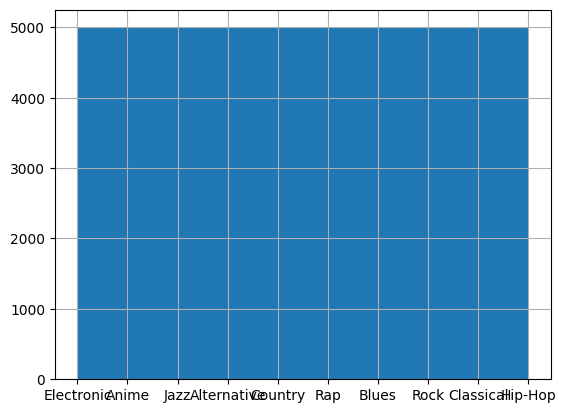

In [31]:

df['music_genre'].hist()

array([[<Axes: title={'center': 'popularity'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>],
       [<Axes: title={'center': 'duration_ms'}>,
        <Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'instrumentalness'}>],
       [<Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'valence'}>, <Axes: >, <Axes: >]],
      dtype=object)

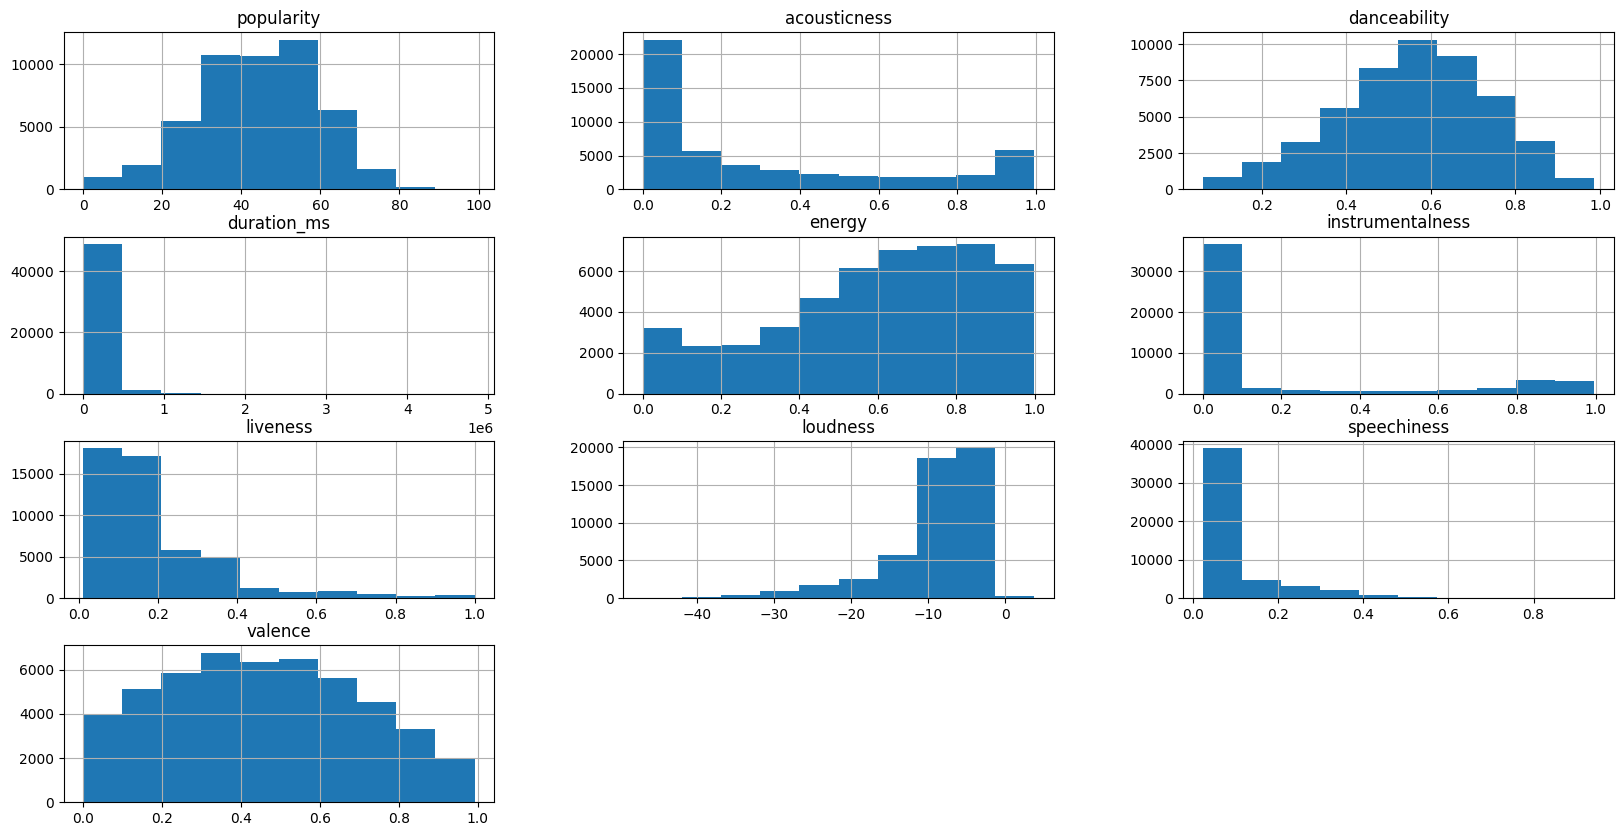

In [32]:
df.hist(figsize=(20, 10))

In [33]:
df.columns

Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'valence', 'music_genre'],
      dtype='object')

In [34]:
# Comparemos el genero con popularidad

grafico_gen_pop = df.groupby(['music_genre'])['popularity'].mean().sort_values(ascending = False)
grafico_gen_pop = grafico_gen_pop.reset_index()
grafico_gen_pop


,music_genre,popularity
0,Rap,60.4974
1,Rock,59.6412
2,Hip-Hop,58.3996
3,Alternative,50.2242
4,Country,46.0100
5,Jazz,40.9286
6,Electronic,38.1118
7,Blues,34.8040
8,Classical,29.3158
9,Anime,24.2716


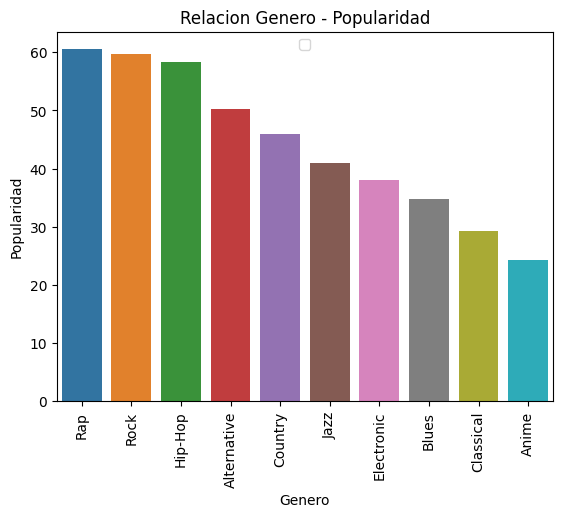

In [35]:
# Grafiquemos algunas relaciones


sns.barplot(x = grafico_gen_pop['music_genre'], y = grafico_gen_pop['popularity'])
plt.title('Relacion Genero - Popularidad')
plt.xticks(rotation = 90)
plt.legend(loc = 'upper center')
plt.xlabel('Genero')
plt.ylabel('Popularidad')
plt.show()


In [36]:
# Comparemos el genero con danceability

grafico_gen_pop1 = df.groupby(['music_genre'])['danceability'].mean().sort_values(ascending = False)
grafico_gen_pop1 = grafico_gen_pop1.reset_index()


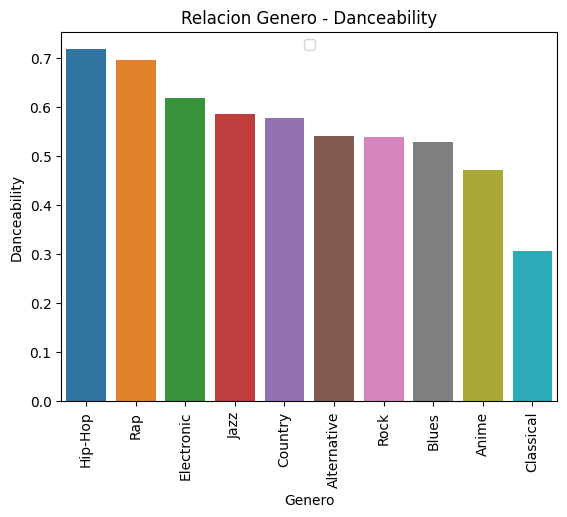

In [37]:
sns.barplot(x = grafico_gen_pop1['music_genre'], y = grafico_gen_pop1['danceability'])
plt.title('Relacion Genero - Danceability')
plt.xticks(rotation = 90)
plt.legend(loc = 'upper center')
plt.xlabel('Genero')
plt.ylabel('Danceability')
plt.show()

In [38]:
# Comparemos el genero con instrumentalness

grafico_gen_pop2 = df.groupby(['music_genre'])['instrumentalness'].mean().sort_values(ascending = False)
grafico_gen_pop2 = grafico_gen_pop2.reset_index()

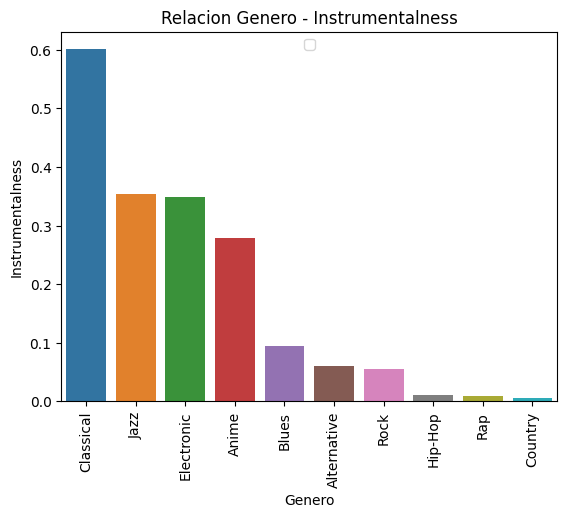

In [39]:
sns.barplot(x = grafico_gen_pop2['music_genre'], y = grafico_gen_pop2['instrumentalness'])
plt.title('Relacion Genero - Instrumentalness')
plt.xticks(rotation = 90)
plt.legend(loc = 'upper center')
plt.xlabel('Genero')
plt.ylabel('Instrumentalness')
plt.show()

In [40]:
# Por ultimo categorizaremos nuestra variable objetivo

df['music_genre'] = df['music_genre'].map({'Electronic': 0, 'Anime': 1, 'Jazz': 2, 'Alternative' : 3, 'Country' : 4, 'Rap' : 5, 'Blues' : 6, 'Rock': 7, 'Classical' : 8, 'Hip-Hop' :9})

In [41]:
df['music_genre'].value_counts()

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: music_genre, dtype: int64

<ipython-input-42-0b2e043a4c8d>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

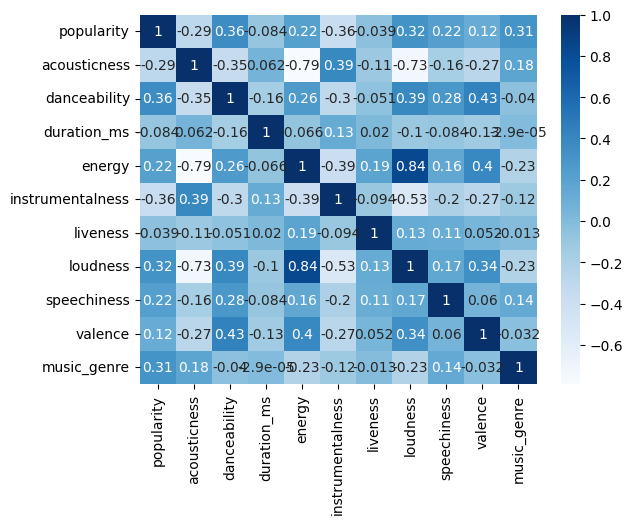

In [42]:
# Veamos ahora un mapa de calor con la variable ya numerica

corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot = True)

In [43]:
df['music_genre'] = df['music_genre'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        50000 non-null  float64
 1   acousticness      50000 non-null  float64
 2   danceability      50000 non-null  float64
 3   duration_ms       50000 non-null  float64
 4   energy            50000 non-null  float64
 5   instrumentalness  50000 non-null  float64
 6   key               50000 non-null  object 
 7   liveness          50000 non-null  float64
 8   loudness          50000 non-null  float64
 9   mode              50000 non-null  object 
 10  speechiness       50000 non-null  float64
 11  valence           50000 non-null  float64
 12  music_genre       50000 non-null  int64  
dtypes: float64(10), int64(1), object(2)
memory usage: 5.3+ MB


In [44]:
# Vamos ahora a implementar modelos de clasificación para predecir el género musical

# Primero veamos el balance de nuestro dataset

df['music_genre'].value_counts(normalize = True)

0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: music_genre, dtype: float64

In [45]:
# Totalmente balanceado

In [46]:
# Vamos con nuestra variable objetivo y train test

X = df.drop(columns = 'music_genre')
y = df['music_genre']

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state=42)

X_train.shape

(35000, 12)

In [47]:
# Vamos con el preprocesamiento

#1 Columnas

cat_selector=make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include= 'number') 

In [48]:
#2 

# Imputers -- No aplican

# Scalers

scaler = StandardScaler()

# One hot

ohe  = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [49]:
# Ahora los pipelines

# Numerica

numeric_pipe= make_pipeline(scaler)
numeric_pipe

Pipeline(steps=[('standardscaler', StandardScaler())])

In [50]:
# Categorica

cat_pipe = make_pipeline(ohe)
cat_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [51]:
# Vamos con la tuplas para transformar

number_tupla = (numeric_pipe, num_selector)
cat_tupla = (cat_pipe, cat_selector)

# Transformador

pre_procesamiento = make_column_transformer(number_tupla, cat_tupla)
pre_procesamiento

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f797150ff10>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f797150f8e0>)])

In [52]:
# hacemos ahora el fit en el train

pre_procesamiento.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f797150ff10>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f797150f8e0>)])

In [53]:
# ahora transformamos train y test

X_train_ok = pre_procesamiento.transform(X_train)
X_test_ok = pre_procesamiento.transform(X_test)

In [54]:
# Comprueben los valores faltantes y que los datos se escalen y tengan una codificación one-hot
print(np.isnan(X_train_ok).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_ok).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_ok.dtype)
print('All data in X_test_processed are', X_test_ok.dtype)
print('\n')
print('shape of data is', X_train_ok.shape)
print('\n')
X_train_ok

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (35000, 24)




array([[ 0.62474375, -0.6855745 , -0.65974957, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.04467625,  1.96027011, -0.11283613, ...,  0.        ,
         1.        ,  0.        ],
       [ 2.04268654, -0.85355998,  1.04795972, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.2692632 ,  0.44752128, -0.88297954, ...,  0.        ,
         1.        ,  0.        ],
       [-1.11545876, -0.57270468, -0.19654737, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.23803208, -0.89448922, -1.02249827, ...,  0.        ,
         1.        ,  0.        ]])

# Decision Tree

In [55]:
# Vamos con el modelo

tree = DecisionTreeClassifier(max_depth = 10, random_state= 42)

In [56]:
# Instanciemos los imputers

scaler = StandardScaler()

In [57]:
# Armemos el pipeline

tree_pipe = make_pipeline(scaler, tree)

In [58]:
# Hacemos el fit en el train
tree_pipe.fit(X_train_ok, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

In [59]:
# Vamos a predecir las salidas para poder evaluar

y_tree = tree_pipe.predict(X_test_ok)
y_tree

array([1, 1, 6, ..., 7, 2, 3])

In [60]:
# Vamos a usar un clasification report para ver distintos indicadores

reporte_tree = classification_report(y_test, y_tree)
print(reporte_tree)

              precision    recall  f1-score   support

           0       0.55      0.50      0.53      1535
           1       0.71      0.69      0.70      1529
           2       0.44      0.42      0.43      1483
           3       0.38      0.36      0.37      1498
           4       0.52      0.49      0.50      1481
           5       0.41      0.53      0.46      1492
           6       0.51      0.46      0.48      1545
           7       0.47      0.68      0.55      1466
           8       0.82      0.77      0.79      1479
           9       0.40      0.29      0.34      1492

    accuracy                           0.52     15000
   macro avg       0.52      0.52      0.52     15000
weighted avg       0.52      0.52      0.52     15000



In [61]:
# Lista de valores a probar para max_depth:
max_depth_range = list(range(2, 36))

accuracy = []
for depth in max_depth_range:
    tree2 = DecisionTreeClassifier(max_depth = depth,random_state = 42)
    tree2_pipe = make_pipeline(scaler, tree2)
    tree2_pipe.fit(X_train_ok, y_train)
    score = tree2_pipe.score(X_test_ok, y_test)
    accuracy.append(score)

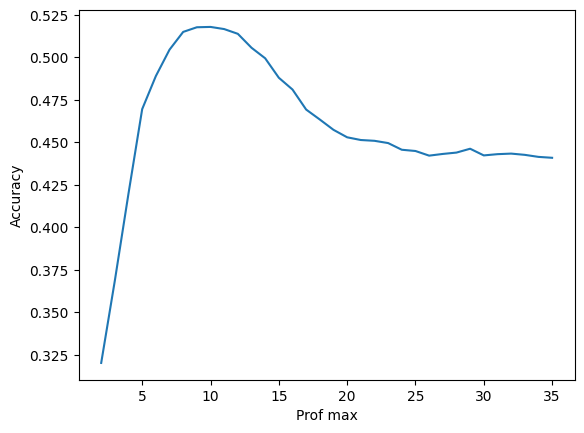

In [62]:
# Grafiquemos lo anterior

plt.plot(max_depth_range, accuracy)
plt.xlabel('Prof max')
plt.ylabel('Accuracy');

# Regresion Logistica

In [63]:
rl = LogisticRegression(C = 1)

In [64]:
# Pipeline

rl_pipe = make_pipeline(scaler, rl)

In [65]:
# Vamos con el fit

rl_pipe.fit(X_train_ok, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1))])

In [66]:
# Predictores

y_rl = rl_pipe.predict(X_test_ok)
y_rl

array([1, 1, 0, ..., 7, 2, 2])

In [67]:
# Classification report

reporte_reg_log = classification_report(y_test, y_rl)

print(reporte_reg_log)

              precision    recall  f1-score   support

           0       0.58      0.57      0.58      1535
           1       0.60      0.61      0.61      1529
           2       0.49      0.42      0.45      1483
           3       0.39      0.31      0.35      1498
           4       0.45      0.59      0.51      1481
           5       0.45      0.36      0.40      1492
           6       0.53      0.47      0.50      1545
           7       0.51      0.64      0.57      1466
           8       0.77      0.80      0.78      1479
           9       0.46      0.50      0.48      1492

    accuracy                           0.53     15000
   macro avg       0.52      0.53      0.52     15000
weighted avg       0.52      0.53      0.52     15000



{0.0001: 0.09773333333333334,
 0.001: 0.43166666666666664,
 0.01: 0.5035333333333334,
 0.1: 0.5066666666666667,
 1: 0.5056666666666667,
 10: 0.5056666666666667,
 100: 0.5058,
 1000: 0.5057333333333334}

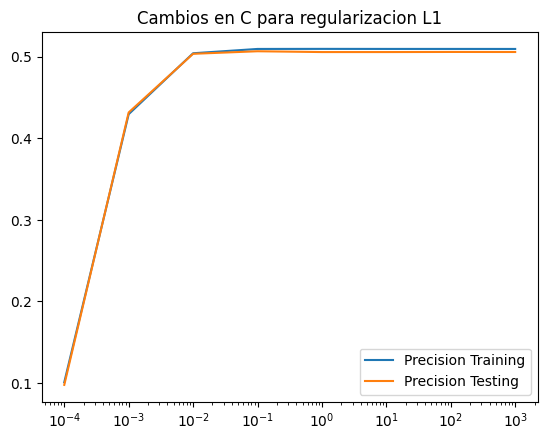

In [68]:
# Mejoremos el modelo ajustando el l1

# Creamos una lista de valores C y listas vacias para guardar los resultados
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
# iteraremos sobre los valores de C
for c in c_values:
 
  # Instanciamos el modelo y hacemos el fit correspondiente
  rl = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l1')
  rl_pipe = make_pipeline(scaler, rl)
  rl_pipe.fit(X_train_ok, y_train)
 
  # ahora agregamos los resultados de la iteracion a las listas
  train_scores.append(rl_pipe.score(X_train_ok, y_train))
  test_scores.append(rl_pipe.score(X_test_ok, y_test))
 
#Lo siguiente grafica la info anterior
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Precision Training')
ax.plot(c_values, test_scores, label='Precision Testing')
ax.set_xticks(c_values)
ax.set_title('Cambios en C para regularizacion L1')
ax.legend()
 
# fijamos la escala como log 
ax.set_xscale('log')
# imprimimos un diccionario con la info de los resultados
{c:score for c, score in zip(c_values, test_scores)}

# Gradient Boosting

In [69]:
%%time
# Instantiate and fit gradient boosting classifier
#xgb = XGBClassifier()
#xgb.fit(X_train_ok, y_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [70]:
#y_xgb = xgb.predict(X_test_ok)
#y_xgb    

In [71]:
#reporte_xgb = classification_report(y_test, y_xgb)
#print(reporte_xgb)

## LightGBM


In [72]:
# Veamos un LightGBM

%%time
# Instantiate and fit gradient boosting classifier
lgbm = LGBMClassifier()
lgbm.fit(X_train_ok, y_train)

CPU times: user 6.04 s, sys: 67.8 ms, total: 6.11 s
Wall time: 3.32 s


LGBMClassifier()

In [73]:
y_lgbm = lgbm.predict(X_test_ok)
y_lgbm

array([0, 1, 0, ..., 7, 8, 3])

In [74]:
reporte_lgbm = classification_report(y_test, y_lgbm)
print(reporte_lgbm)

              precision    recall  f1-score   support

           0       0.68      0.61      0.64      1535
           1       0.79      0.75      0.77      1529
           2       0.54      0.56      0.55      1483
           3       0.45      0.39      0.42      1498
           4       0.58      0.59      0.59      1481
           5       0.37      0.39      0.38      1492
           6       0.63      0.55      0.59      1545
           7       0.51      0.68      0.58      1466
           8       0.86      0.84      0.85      1479
           9       0.39      0.40      0.40      1492

    accuracy                           0.58     15000
   macro avg       0.58      0.58      0.58     15000
weighted avg       0.58      0.58      0.58     15000



## GradientBoostingClassifier


In [75]:
%%time
#gbc = GradientBoostingClassifier()
#gbc.fit(X_train_ok, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [76]:
#y_gbc = gbc.predict(X_test_ok)
#y_gbc

In [77]:
#reporte_gbc = classification_report(y_test, y_gbc)
#print(reporte_gbc)

In [78]:
# Light GBM nos entrega la mejor accuracy con el menor tiempo de carga

# Vamos a probar ahora con redes neuronales

In [79]:
# Importante destacar que es un modelo multiclase
# La capa de salida deberá tener tantos nodos como clases

In [80]:
X_test_ok.shape

(15000, 24)

In [81]:
# Recordemos las clases de nuestro modelo

df['music_genre'].value_counts()

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: music_genre, dtype: int64

In [82]:
# Son 10 en total

In [83]:
# Definamos la red y cantidad de neuronas

input_shape = X_train_ok.shape[1]
input_shape

24

In [84]:
# Vamos con el modelo bruto

model = Sequential()

In [85]:
# Ahora con las capas

#1 
model.add(Dense(24, input_dim = input_shape, activation = 'relu'))

#2
model.add(Dense(18, input_dim = input_shape, activation = 'relu'))

#3
model.add(Dense(12, input_dim = input_shape, activation = 'relu'))

# Salida
model.add(Dense(10, activation = 'softmax'))

In [86]:
# Ahora compilaremos el modelo
# Para evaluar el modelo usaremos accuracy

#loss = keras.losses.CategoricalCrossentropy()

#model.compile(loss=loss, optimizer = 'adam', metrics=['accuracy'])


In [87]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", # Existen principalmente dos optimizadores, adam y sgd. En la práctica, escoger uno u otro no hace gran diferencia
              metrics=["accuracy"])


In [88]:
# Ahora ajustamos el modelo

history = model.fit(X_train_ok, y_train, validation_data = (X_test_ok, y_test), epochs = 10)

Epoch 1/10
1094/1094 [==============================] - 3s 2ms/step - loss: 2.0785 - accuracy: 0.2339 - val_loss: 1.8397 - val_accuracy: 0.3344
Epoch 2/10
1094/1094 [==============================] - 2s 2ms/step - loss: 1.5741 - accuracy: 0.4168 - val_loss: 1.3978 - val_accuracy: 0.4774
Epoch 3/10
1094/1094 [==============================] - 2s 2ms/step - loss: 1.3405 - accuracy: 0.4917 - val_loss: 1.3096 - val_accuracy: 0.5074
Epoch 4/10
1094/1094 [==============================] - 2s 2ms/step - loss: 1.2881 - accuracy: 0.5078 - val_loss: 1.2719 - val_accuracy: 0.5147
Epoch 5/10
1094/1094 [==============================] - 2s 2ms/step - loss: 1.2577 - accuracy: 0.5203 - val_loss: 1.2477 - val_accuracy: 0.5257
Epoch 6/10
1094/1094 [==============================] - 2s 2ms/step - loss: 1.2359 - accuracy: 0.5297 - val_loss: 1.2303 - val_accuracy: 0.5302
Epoch 7/10
1094/1094 [==============================] - 2s 2ms/step - loss: 1.2206 - accuracy: 0.5337 - val_loss: 1.2292 - val_accuracy:

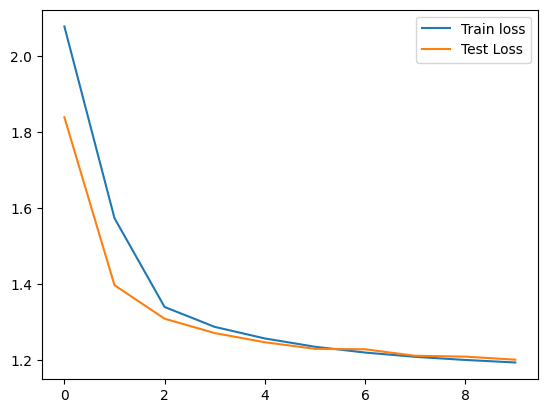

In [89]:
# Visualicemos

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

In [97]:
# Vamos con el modelo bruto

model_v_2 = Sequential()

In [98]:
# Ahora con las capas

#1 
model_v_2.add(Dense(24, input_dim = input_shape, activation = 'relu'))

#2
model_v_2.add(Dense(22, input_dim = input_shape, activation = 'relu'))

#3
model_v_2.add(Dense(15, input_dim = input_shape, activation = 'relu'))

# Salida
model_v_2.add(Dense(10, activation = 'softmax'))

In [99]:
model_v_2.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", # Existen principalmente dos optimizadores, adam y sgd. En la práctica, escoger uno u otro no hace gran diferencia
              metrics=["accuracy"])

In [100]:
early_stopping = EarlyStopping(patience = 4)

In [101]:
# Ahora ajustamos el modelo

history = model_v_2.fit(X_train_ok, y_train, validation_data = (X_test_ok, y_test), callbacks = [early_stopping], epochs = 150)

Epoch 1/150
1094/1094 [==============================] - 2s 2ms/step - loss: 2.1979 - accuracy: 0.1855 - val_loss: 1.9243 - val_accuracy: 0.3095
Epoch 2/150
1094/1094 [==============================] - 2s 2ms/step - loss: 1.6225 - accuracy: 0.3927 - val_loss: 1.4436 - val_accuracy: 0.4543
Epoch 3/150
1094/1094 [==============================] - 2s 2ms/step - loss: 1.3815 - accuracy: 0.4840 - val_loss: 1.3340 - val_accuracy: 0.4985
Epoch 4/150
1094/1094 [==============================] - 2s 2ms/step - loss: 1.3026 - accuracy: 0.5097 - val_loss: 1.2814 - val_accuracy: 0.5167
Epoch 5/150
1094/1094 [==============================] - 2s 2ms/step - loss: 1.2613 - accuracy: 0.5218 - val_loss: 1.2532 - val_accuracy: 0.5243
Epoch 6/150
1094/1094 [==============================] - 2s 2ms/step - loss: 1.2388 - accuracy: 0.5297 - val_loss: 1.2394 - val_accuracy: 0.5268
Epoch 7/150
1094/1094 [==============================] - 2s 2ms/step - loss: 1.2241 - accuracy: 0.5345 - val_loss: 1.2289 - val_ac

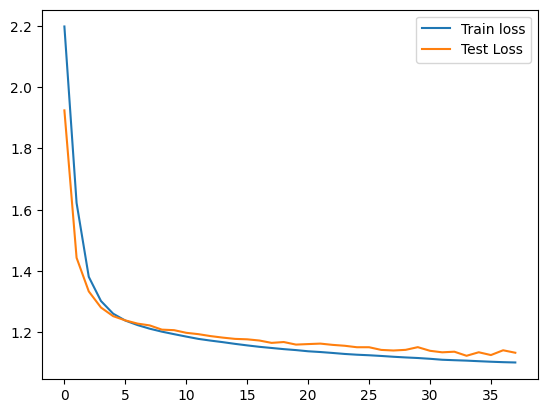

In [102]:
# Visualicemos

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();